In [ ]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, AveragePooling2D, concatenate
from keras.models import Model
# 비선형적 모델설계에 사용 , multi input, multi output 지원
from keras.preprocessing.image import ImageDataGenerator
# 데이터 증강과 배치를 생성하여 데이터 학습의 정확도를 높임.
import numpy as np
import tensorflow as tf
from keras.utils import np_utils

width = 32
height = 32
# cifar10데이터셋의 크기(8000만개 작은 이미지 데이터세트의 하위셋)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


https://www.tensorflow.org/api_docs/python/tf/keras/applications/InceptionV3

In [ ]:
num_classes = 10
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
# 원핫인코딩해줌

In [ ]:
validation_images, validation_labels = x_train[:500], y_train[:500]
train_images, train_labels = x_train[500:], y_train[500:]

In [ ]:
train_images.shape

(49500, 32, 32, 3)

In [ ]:
# 레이어 x를 받아서 4개의 output layer을 뽑아서 concat한 레이어를 출력
def inception(x, filters): 
    pre_layer = x
    
    f1,f2,f3,f4 = filters   # filter 갯수

    # 1x1
    conv1 = Conv2D(f1, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    
    # 1x1 & 3x3
    conv2 = Conv2D(f4  , kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv2 = Conv2D(f2, kernel_size=(3,3), padding='same', activation='relu')(conv2)

    # 1x1 & 5x5
    conv3 = Conv2D(f4, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv3 = Conv2D(f3, kernel_size=(5,5), padding='same', activation='relu')(conv3)
    
    # pooling & 1x1
    max_pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre_layer)
    max_pool = Conv2D(f4, kernel_size=(1,1), padding='same')(max_pool)

    # output = [None(batch_size), w,h,c], c 기준 concatenate (axis = -1 )
    concat = concatenate([conv1, conv2, conv3, max_pool], axis=-1)
    
    return concat
    

In [ ]:
from google.colab import drive
drive.mount('/mydrive', force_remount=True)

Mounted at /mydrive


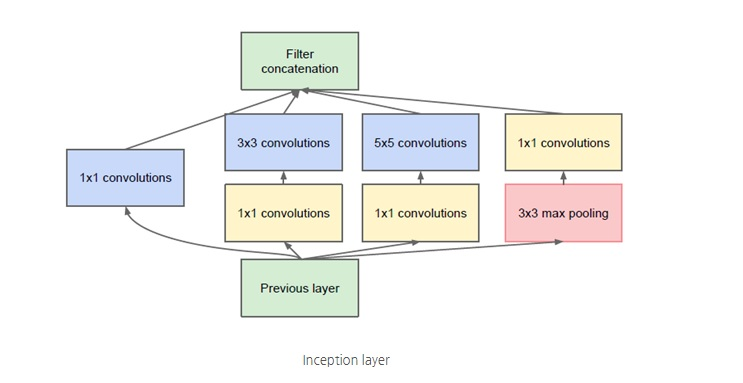

In [ ]:
from IPython.display import Image 
Image('./googlenet.jpg')

In [ ]:
cd MyDrive

/mydrive/MyDrive


In [ ]:
ls

In [ ]:
ls

In [ ]:
x_train[0].shape

In [ ]:
input

In [ ]:
inputs

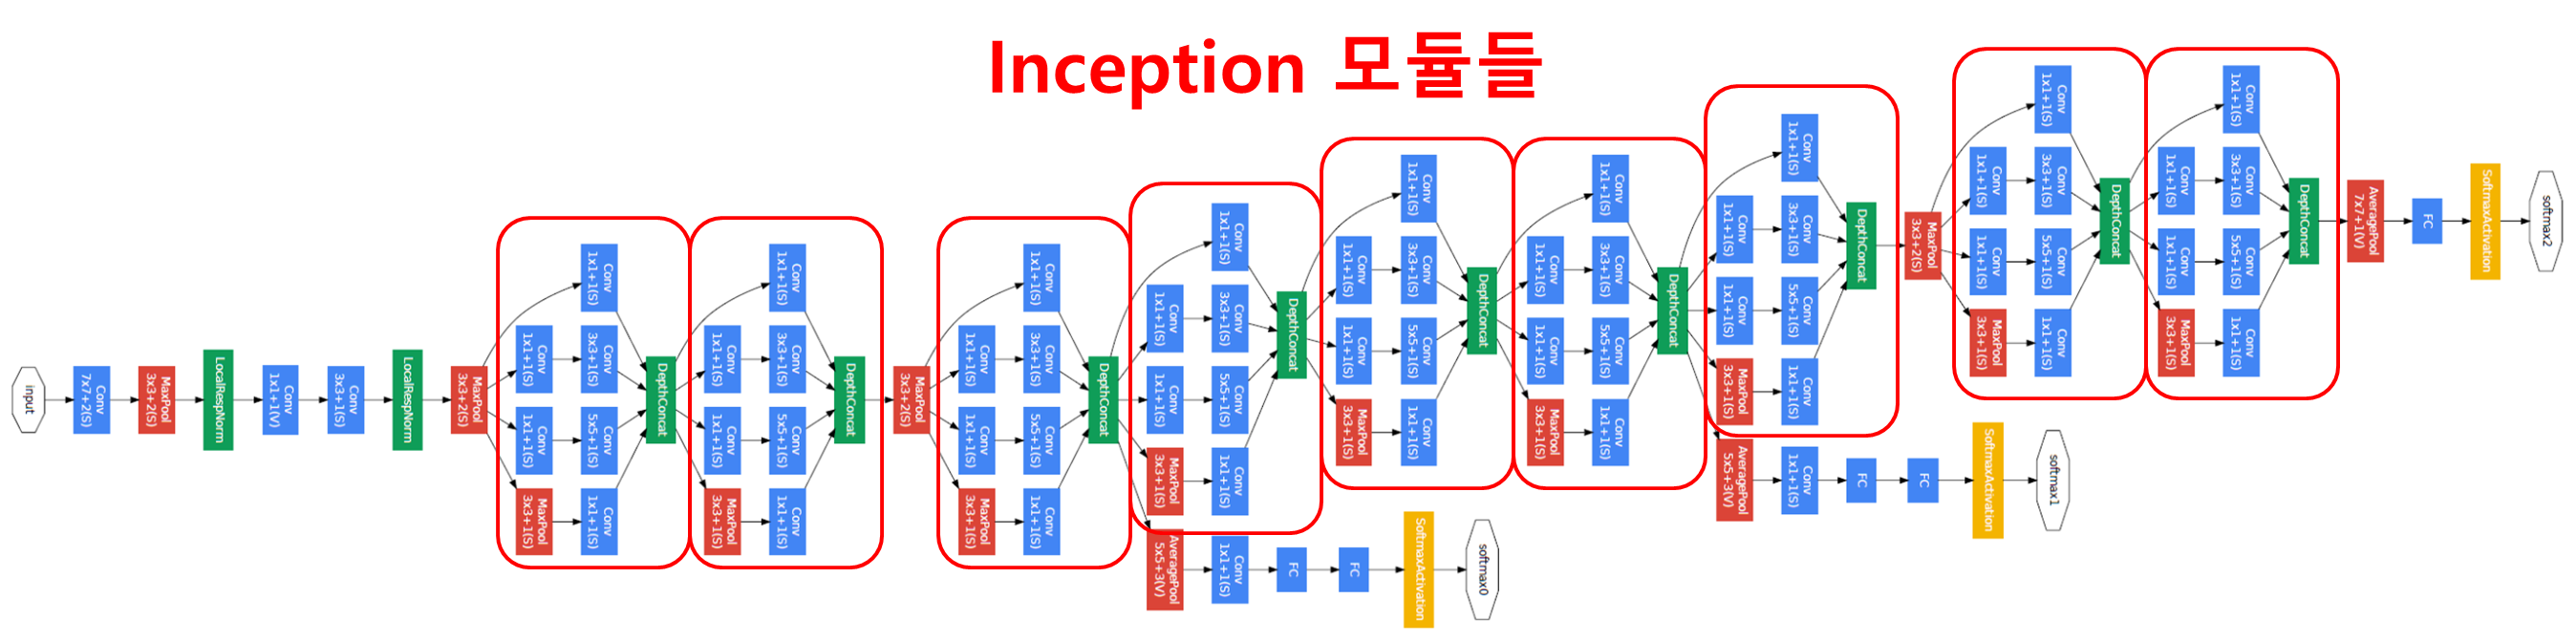

In [ ]:
from IPython.display import Image 
Image('./googlenet_2.png')

In [ ]:
input_shape = x_train[0].shape    
inputs = Input(shape=input_shape)

# conv랑 batch 사이에 max pooling 들어가야 하나, cifar 데이터에선 크기 너무 줄어들어서 뺐음
x = Conv2D(64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(192, kernel_size=(3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x) 

#inception (input, [#1x1conv, #3x3conv, #5x5conv, #1x1reduction] )

# inception 3a
x = inception(x,[64,128,32,32]) # 4개의 output을 하나로 삼는데 각각 convolution에 필터를 넣게 할지는 파라미터로 넘겨줌.
# inception 3b
x = inception(x,[128,192,96,64])
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

# inception 4a
x = inception(x,[192,208,48,64])

aux1 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x) #크기가 줄어듬
aux1 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux1) 
aux1 = Flatten()(aux1) #벡터라이징
aux1 = Dense(512, activation='relu')(aux1)
aux1 = Dense(10, activation='softmax')(aux1)
# convolution 2번 ,  inception 2번, maxpoolingn 하고 인셉션해서 나온값을
# 그다음 인셉션에 넣어서 쭉 가는데 그전에 작은 classifierdense를 만들어서 하나의 예측값을 뽑음.

# inception 4b
x = inception(x,[160,224,64,64])
# inception 4c
x = inception(x,[128,256,64,64])
# inception 4d
x = inception(x,[112,288,64,64])
aux2 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
aux2 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux2)
aux2 = Flatten()(aux2)
aux2 = Dense(832, activation='relu')(aux2)
aux2 = Dense(10, activation='softmax')(aux2)


# inception 4e
x = inception(x,[256,320,128,128])


# inception 5a
x = inception(x,[256,320,128,128])
# inception 5b
x = inception(x,[384,384,128,128])
x = AveragePooling2D(pool_size=(4,4), padding='valid')(x)
x = Dropout(0.4)(x) #과적합을 최소화하기위해 노드를 랜덤하게 끔.. 40퍼정도
x = Flatten()(x)

outputs = Dense(10, activation='softmax')(x)
# multiclassification 이니 softmax 


In [ ]:
model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])

model.compile(optimizer='adam', loss='categorical_crossentropy', loss_weights=[0.3,0.3,1.0], metrics=['accuracy']) 


In [ ]:
model.summary()

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
# 기울이기, 확대, 위아래바꾸기, normalization 해서 데이터를 생성해서가져옴
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
history = model.fit(train_datagen.flow(train_images,train_labels, batch_size = 32), # 이미지와 라벨을 배치단위로가져옴
                    validation_data = validation_datagen.flow(validation_images, validation_labels, batch_size = 32), # flow를 통해 validation(변수)데이터를 배치사이즈만큼 가져옴
                    epochs = 10)
# 트레인이미지와 라벨에서 배치사이즈만큼 데이터를 계속 가져와서 fitting해서 학습시킴.

Epoch 1/10
1547/1547 [==============================] - 217s 131ms/step - loss: 2.6246 - dense_1_loss: 1.5757 - dense_3_loss: 1.6268 - dense_4_loss: 1.6638 - dense_1_accuracy: 0.4184 - dense_3_accuracy: 0.3955 - dense_4_accuracy: 0.3849 - val_loss: 2.3845 - val_dense_1_loss: 1.4535 - val_dense_3_loss: 1.4581 - val_dense_4_loss: 1.5110 - val_dense_1_accuracy: 0.4560 - val_dense_3_accuracy: 0.4440 - val_dense_4_accuracy: 0.4380
Epoch 2/10
1547/1547 [==============================] - 198s 128ms/step - loss: 1.9804 - dense_1_loss: 1.1875 - dense_3_loss: 1.2214 - dense_4_loss: 1.2578 - dense_1_accuracy: 0.5745 - dense_3_accuracy: 0.5645 - dense_4_accuracy: 0.5492 - val_loss: 1.8730 - val_dense_1_loss: 1.2158 - val_dense_3_loss: 1.1807 - val_dense_4_loss: 1.1540 - val_dense_1_accuracy: 0.5620 - val_dense_3_accuracy: 0.5760 - val_dense_4_accuracy: 0.5860
Epoch 3/10
1547/1547 [==============================] - 198s 128ms/step - loss: 1.6505 - dense_1_loss: 0.9932 - dense_3_loss: 1.0144 - dense

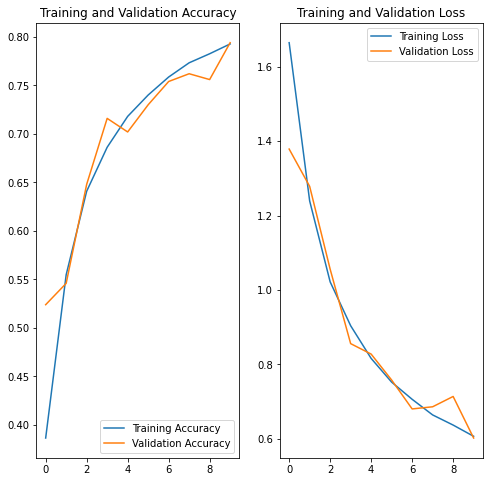

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['dense_4_accuracy']
val_acc = history.history['val_dense_4_accuracy']

loss = history.history['dense_4_loss']
val_loss = history.history['val_dense_4_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()